# Read data and randoms clsutering catalogs: 

**Aim:** Read data and randoms clustering catalogs from GLAM mocks with the expand option for the randoms. 

**Important:** This code can be run with MPI (srun -n X python ... ).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import numpy as np

import logging
from mpytools import Catalog, setup_logging

sys.path.append('../')
from clustering_statistics.tools import read_clustering_catalog, get_catalog_fn, propose_fiducial, _compute_binned_weight, select_region, _read_catalog

from mpi4py import MPI
mpicomm = MPI.COMM_WORLD

setup_logging(level=(logging.INFO if mpicomm.rank == 0 else logging.ERROR))

In [3]:
attrs = {'version': 'glam-uchuu-v1-altmtl', 'tracer': 'QSO', 'region': 'NGC', 'imock': 100, 'nran': 4}

print('data are located: ', get_catalog_fn(kind='data', **attrs))
print('randoms are located: ', get_catalog_fn(kind='randoms', **attrs))

# need to compute WEIGHT_FKP for expanded catalogs .. (should be automatized in the future)
attrs['FKP_P0'] = propose_fiducial('catalog', tracer=attrs['tracer'], analysis='full_shape')['FKP_P0']
print(attrs['FKP_P0'])

data are located:  /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5
randoms are located:  [PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_0_clustering.ran.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_1_clustering.ran.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_2_clustering.ran.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_3_clustering.ran.h5')]
6000.0


In [4]:
# Can pass other functions to get catalog fn, default is: get_catalog_fn = get_catalog_fn
data = read_clustering_catalog(kind='data', weight='fkp', return_all_columns=True, mpicomm=mpicomm, **attrs) 
print(data)

[000000.34] [0/1] 02-11 20:00  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000000.40] [0/1] 02-11 20:00  tools                     INFO     Multiplying individual weights by WEIGHT_FKP


INFO:2026-02-11 20:00:12,671:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[000000.81] [0/1] 02-11 20:00  jax._src.xla_bridge       INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Catalog(csize=1344031, size=1344031, columns=['RA', 'DEC', 'Z', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_FKP', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'FRAC_TLOBS_TILES', 'NTILE', 'NX', 'TARGETID', 'INDWEIGHT', 'POSITION'])


In [5]:
# you can recover the values from 'WEIGHT' column by:
weight_ntl = _compute_binned_weight(data['NTILE'], data['WEIGHT_COMP'])[data['NTILE']] # mean completeness weight as a function of 'NTILE'
weight = data['WEIGHT_COMP'] * data['WEIGHT_SYS'] * data['WEIGHT_ZFAIL'] / weight_ntl
print(data['WEIGHT'])
print(weight)

[1.64160156 0.82080078 0.83007812 ... 0.96044922 0.95654297 0.95898438]
[1.64132121 0.82025252 0.83004658 ... 0.96060227 0.95685358 0.95919651]


In [10]:
expand = {'parent_randoms_fn': get_catalog_fn(kind='parent_randoms', version='data-dr2-v2', tracer=attrs['tracer'], nran=attrs['nran'])}
randoms = read_clustering_catalog(kind='randoms', weight='fkp', expand=expand, return_all_columns=True, mpicomm=mpicomm, **attrs) 
print(randoms)

[000654.92] [0/1] 02-11 20:11  tools                     INFO     Expanding randoms
[000654.92] [0/1] 02-11 20:11  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_0_full_noveto.ran.h5.
[000655.04] [0/1] 02-11 20:11  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_1_full_noveto.ran.h5.
[000655.15] [0/1] 02-11 20:11  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_2_full_noveto.ran.h5.
[000655.26] [0/1] 02-11 20:11  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_3_full_noveto.ran.h5.
[000655.36] [0/1] 02-11 20:11  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000655.37] [0/1] 02-11 20:11  FileStack                 

In [7]:
# you can also reshuffle randoms on the fly (this is slow without MPI)
# pass expand if randoms do not have RA, DEC, and NTILE columns
expand    = {'parent_randoms_fn': get_catalog_fn(kind='parent_randoms', version='data-dr2-v2', tracer=attrs['tracer'], nran=attrs['nran'])}
# provide directory to merged data catalogs
merged_dir = Path(os.getenv('SCRATCH')) / 'cai-dr2-benchmarks' /  attrs['version'] / 'merged'
reshuffle = {'merged_data_fn': get_catalog_fn(kind='data', cat_dir=merged_dir, **(attrs|dict(region='ALL')))}
randoms_reshuffled = read_clustering_catalog(kind='randoms', weight='fkp', expand=expand, reshuffle=reshuffle, return_all_columns=True, mpicomm=mpicomm, **attrs) 
print(randoms)

[000072.07] [0/1] 02-11 20:01  tools                     INFO     Expanding randoms
[000072.07] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_0_full_noveto.ran.h5.
[000072.19] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_1_full_noveto.ran.h5.
[000072.31] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_2_full_noveto.ran.h5.
[000072.42] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_3_full_noveto.ran.h5.
[000072.54] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000072.54] [0/1] 02-11 20:01  FileStack                 

/global/u2/a/arosado/cai-dr2-clustering-products/nb/../clustering_statistics/tools.py:882: UserWarning: TARGETID not in catalog
  warnings.warn('TARGETID not in catalog')


[000073.33] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000073.33] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_clustering.dat.h5.
[000073.34] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_0_clustering.ran.h5.
[000073.34] [0/1] 02-11 20:01  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_0_clustering.ran.h5.
[000088.46] [0/1] 02-11 20:01  tools                     INFO     Reshuffling randoms started.
[000110.05] [0/1] 02-11 20:02  Footprint                 INFO     Load DR9 footprint with nside=256, mask_lmc=False, clea

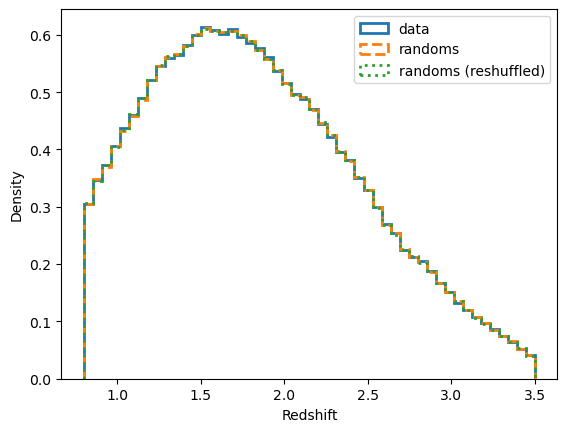

In [8]:
import matplotlib.pyplot as plt
hist_kws = dict(bins=50, histtype='step', density=True, lw=2)
plt.hist(data['Z'], weights=data['INDWEIGHT'], label='data', ls='-', **hist_kws)
plt.hist(randoms['Z'], weights=randoms['INDWEIGHT'], label='randoms', ls='--', **hist_kws)
plt.hist(randoms_reshuffled['Z'], weights=randoms_reshuffled['INDWEIGHT'], label='randoms (reshuffled)', ls=':', **hist_kws)
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.legend()
plt.show()